In [1]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [2]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

/opt/miniconda3/envs/gov-data/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')

# Calculate 10% of the total number of rows
sample_size = int(df.height * 0.8)

# Get a 10% random sample of the data
df = df.sample(n=sample_size, with_replacement=False, shuffle=True, seed=42)

print(df)

shape: (258_424, 47)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ NoticeId  ┆ Title     ┆ Sol#      ┆ Departmen ┆ … ┆ CountryCo ┆ Additiona ┆ Link      ┆ Descript │
│ ---       ┆ ---       ┆ ---       ┆ t/Ind.Age ┆   ┆ de        ┆ lInfoLink ┆ ---       ┆ ion      │
│ str       ┆ str       ┆ str       ┆ ncy       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆           ┆ ---       ┆   ┆ str       ┆ str       ┆           ┆ str      │
│           ┆           ┆           ┆ str       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ bc5e5f04c ┆ 15--FAIRI ┆ N0038322R ┆ DEPT OF   ┆ … ┆ USA       ┆           ┆ https://s ┆          │
│ 916465799 ┆ NG,AIRCRA ┆ F342      ┆ DEFENSE   ┆   ┆           ┆           ┆ am.gov/op ┆          │
│ 33a4c0bdc ┆ FT        ┆           ┆           ┆   ┆           ┆     

In [4]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)

In [5]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 258424        ┆ 0              │
│ title                 ┆ 117973        ┆ 0              │
│ sol_                  ┆ 166538        ┆ 0              │
│ department_ind_agency ┆ 73            ┆ 0              │
│ cgac                  ┆ 69            ┆ 7              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 1307          ┆ 0              │
│ countrycode           ┆ 61            ┆ 0              │
│ additionalinfolink    ┆ 2             ┆ 0              │
│ link                  ┆ 258424        ┆ 0              │
│ description           ┆ 184939        ┆ 0              │
└───────────────────────┴───────────────┴

In [6]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code',
                     'office', 'aac_code', 'posteddate', 'type', 'basetype', 
                     'archivetype', 'archivedate', 'setasidecode', 'setaside', 
                     'responsedeadline', 'naicscode', 'classificationcode', 
                     'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
                    'awardnumber', 'awarddate', 'awardee', 'state', 'city', 
                    'zipcode', 'countrycode', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [7]:
df2022.schema

Schema([('noticeid', String),
        ('title', String),
        ('sol_', String),
        ('department_ind_agency', String),
        ('cgac', Int64),
        ('sub_tier', String),
        ('fpds_code', String),
        ('office', String),
        ('aac_code', String),
        ('posteddate', String),
        ('type', String),
        ('basetype', String),
        ('archivetype', String),
        ('archivedate', String),
        ('setasidecode', String),
        ('setaside', String),
        ('responsedeadline', String),
        ('naicscode', String),
        ('classificationcode', String),
        ('popstreetaddress', String),
        ('popcity', String),
        ('popstate', String),
        ('popzip', String),
        ('popcountry', String),
        ('active', String),
        ('awardnumber', String),
        ('awarddate', String),
        ('award_', String),
        ('awardee', String),
        ('primarycontacttitle', String),
        ('primarycontactfullname', String),
        ('pr

In [8]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Handle potential errors if 'award_' contains non-numeric values
# You can also choose to fill missing values or drop rows with invalid 'award_' entries
df = df.drop_nulls(subset=['award_'])
df

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""bc5e5f04c91646579933a4c0bdc456…","""15--FAIRING,AIRCRAFT""","""N0038322RF342""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-06-30 07:10:57.475-04""","""Award Notice""","""Award Notice""","""autocustom""","""2022-07-14""","""""","""""","""""","""""","""1560""","""""","""""","""""","""""","""""","""No""","""N0038322FX900""","""2022-06-29""","""1165526""","""SIKORSKY AIRCRAFT CORP, STRATF…","""""","""KAITLYN R. SAWICKI, N732.50, P…","""KAITLYN.SAWICKI@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/bc5e5f04c9…",""""""
"""a233c35e1ba243928140f6d84b9611…","""V127--Armored Car Services""","""36C24622Q0748""","""VETERANS AFFAIRS, DEPARTMENT O…",36,"""VETERANS AFFAIRS, DEPARTMENT O…","""3600""","""246-NETWORK CONTRACTING OFFICE…","""36C246""","""2022-07-05 09:42:28.136-04""","""Solicitation""","""Solicitation""","""autocustom""","""2022-08-11""","""""","""""","""2022-07-12T14:00:00-04:00""","""561613""","""V127""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""null ""","""Contracting Officer""","""Paul O Waite""","""Paul.Waite@va.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""VA""","""HAMPTON""","""23667""","""USA""","""""","""https://sam.gov/opp/a233c35e1b…","""Amendment to Solicitation to u…"
"""26f9fe72dcfc4e03b9268f7e869e40…","""IDIQ for Financial Management …","""75P00120R00180""","""HEALTH AND HUMAN SERVICES, DEP…",75,"""OFFICE OF THE ASSISTANT SECRET…","""7570""","""PROGRAM SUPPORT CENTER ACQ MGM…","""75P001""","""2022-02-07 10:59:47.707-05""","""Combined Synopsis/Solicitation""","""Combined Synopsis/Solicitation""","""autocustom""","""2022-05-30""","""8A""","""8(a) Set-Aside (FAR 19.8)""","""2022-02-21T11:00:00-05:00""","""541219""","""R703""","""""","""Bethesda""","""MD""","""20814""","""USA""","""No""","""""","""""","""""","""""","""""","""Wendy Cruz""","""wendy.cruz@psc.hhs.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""MD""","""ROCKVILLE""","""20857""","""USA""","""""","""https://sam.gov/opp/26f9fe72dc…","""This is a combined synopsis/so…"
"""7df37f39a80f4e549a8082ab149982…","""Animal Care and Technical Proc…","""75F40122R1259563""","""HEALTH AND HUMAN SERVICES, DEP…",75,"""FOOD AND DRUG ADMINISTRATION""","""7524""","""FDA NATIONAL CENTER FOR TOXICO…","""75DAEC""","""2022-04-12 17:19:47.468-04""","""Sources Sought""","""Sources Sought""","""auto15""","""""","""""","""""","""2022-04-27T14:00:00-05:00""","""541714""","""R416""","""""","""Jefferson""","""AR""","""72079""","""USA""","""No""","""""","""""","""""","""""","""""","""Tim Walbert""","""timothy.walbert@fda.hhs.gov""","""8705437267""","""""","""""","""""","""""","""""","""""","""OFFICE""","""MD""","""Silver Spring""","""20993""","""USA""","""""","""https://sam.gov/opp/7df37f39a8…","""MARKET RESEARCH PURPOSES ONLY …"
"""0054de1834474a90820b5234927a22…","""Septic Pumps Replacement, Quec…","""W912WJ22Q0156""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""W2SD ENDIST NEW ENGLAND""","""W912WJ""","""2022-09-23 13:51:05.796-04""","""Solicitati

In [9]:
!pip install --upgrade polars

In [10]:
# Calculate total awards per sub_tier
total_awards_df = df.group_by('sub_tier').agg(pl.col('award_').sum().alias('total_award'))
# Sort departments alphabetically
total_awards_df = total_awards_df.sort('sub_tier')
total_awards_df

sub_tier,total_award
str,str
"""""",null
"""ADMINISTRATION FOR CHILDREN AN…",null
"""ADMINISTRATIVE OFFICE OF THE U…",null
"""AGENCY FOR HEALTHCARE RESEARCH…",null
"""AGENCY FOR INTERNATIONAL DEVEL…",null
…,…
"""US TRANSPORTATION COMMAND (UST…",null
"""USDA, DEPARTMENTAL ADMINISTRAT…",null
"""USDA, OFFICE OF PROCUREMENT AN…",null


In [11]:
# Calculate total awards per department_ind_agency
total_awards_df = df.group_by('department_ind_agency').agg(pl.col('award_').sum().alias('total_award'))

# Sort departments alphabetically
total_awards_df = total_awards_df.sort('department_ind_agency')

# Extract departments and total awards
departments = total_awards_df['department_ind_agency'].to_list()
total_awards = total_awards_df['total_award'].to_list()

# Determine the number of chunks
num_chunks = 4
chunk_size = len(departments) // num_chunks
chunks = [departments[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining departments, add them to the last chunk
if len(departments) % num_chunks != 0:
    chunks[-1].extend(departments[num_chunks * chunk_size:])

# Similarly split total_awards into chunks
total_awards_chunks = [total_awards[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]
if len(total_awards) % num_chunks != 0:
    total_awards_chunks[-1].extend(total_awards[num_chunks * chunk_size:])

In [12]:
# Clean the 'award_' column by removing '$' and ',' and converting to float
df = df.with_columns([
    pl.col('award_')
    .str.replace_all(r'[\$,]', '')  # Remove '$' and ','
    .cast(pl.Float64, strict=False)  # Convert to float, allow failures
    .alias('award_')
])

# Drop rows where 'award_' could not be converted to float
df = df.drop_nulls(subset=['award_'])

# Calculate total awards per 'sub_tier'
total_awards_df = df.group_by('sub_tier').agg(
    pl.col('award_').sum().alias('total_award')
)

# Sort sub_tiers alphabetically
total_awards_df = total_awards_df.sort('sub_tier')

# Extract sub_tiers and total awards
departments = total_awards_df['sub_tier'].to_list()
total_awards = total_awards_df['total_award'].to_list()

# Ensure departments and total_awards are properly defined
print("Number of departments:", len(departments))
print("Number of total awards:", len(total_awards))

Number of departments: 127
Number of total awards: 127


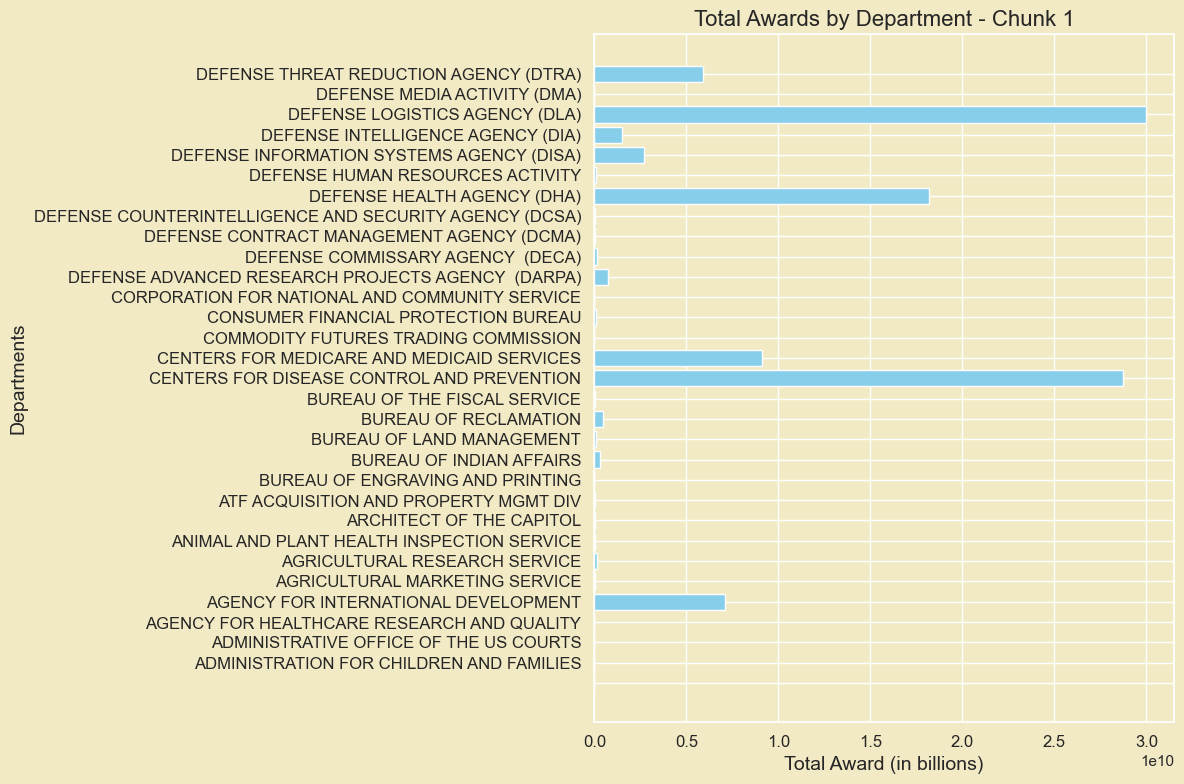

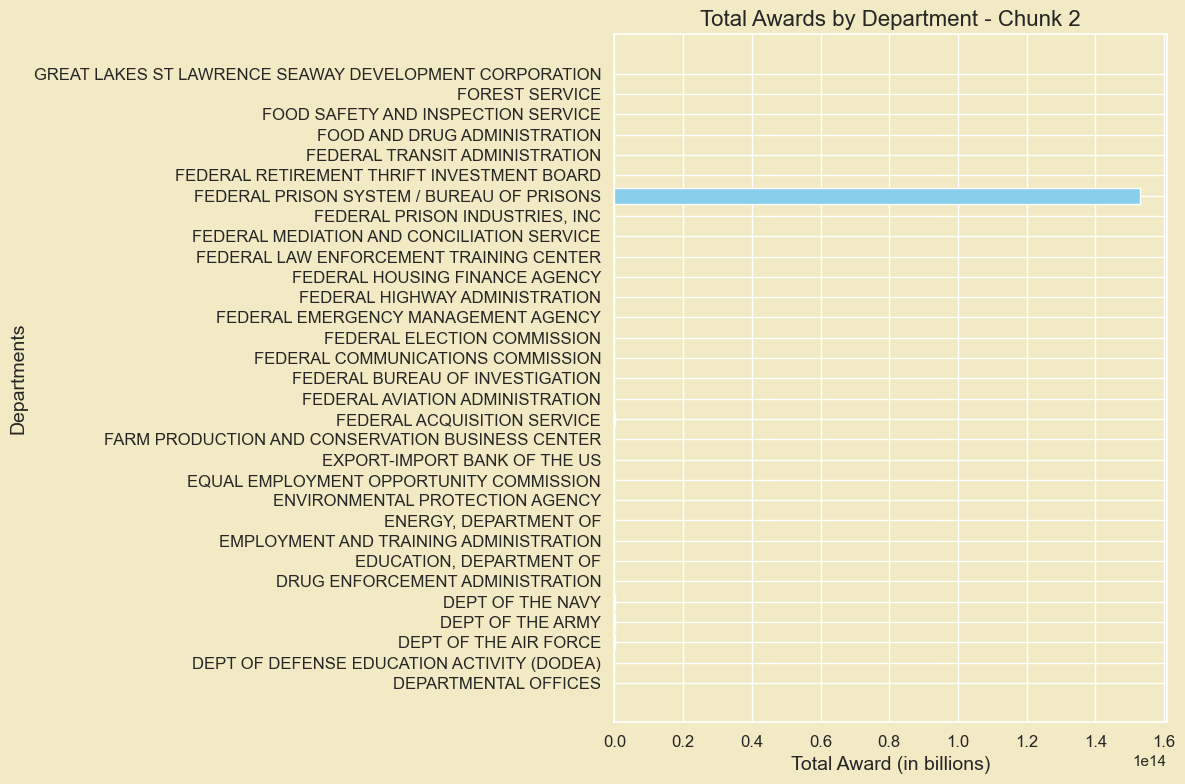

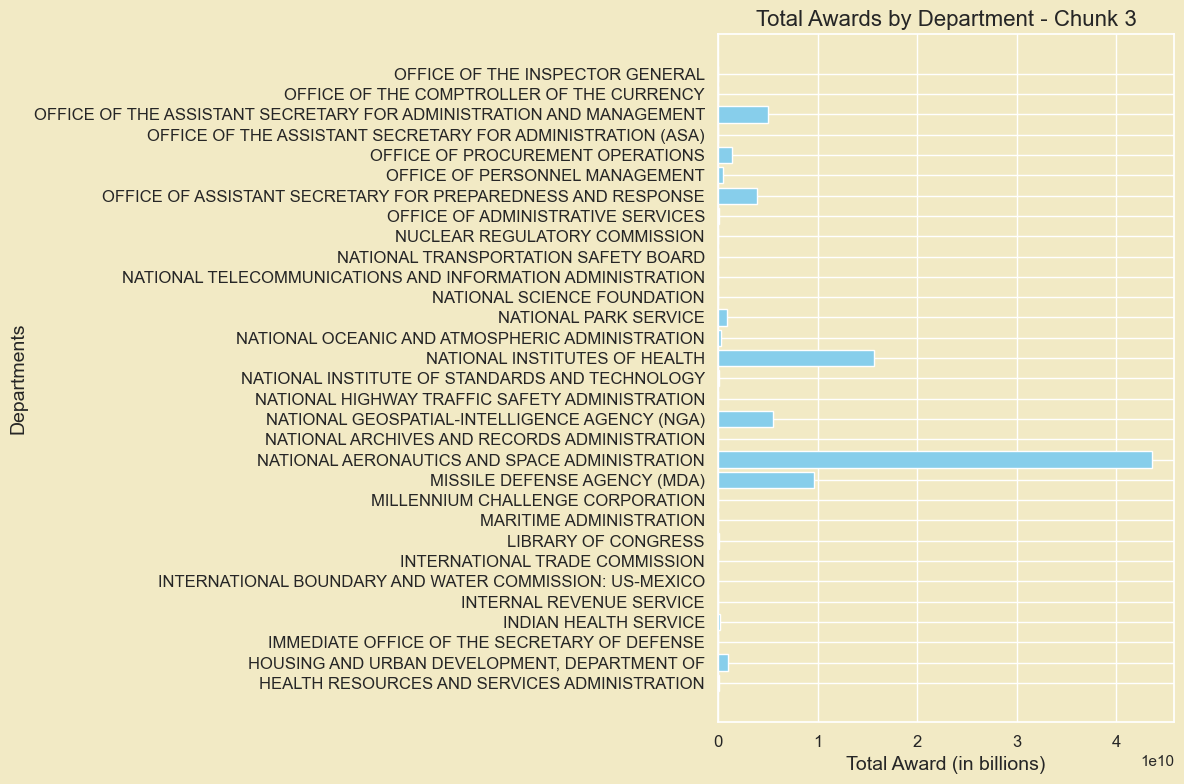

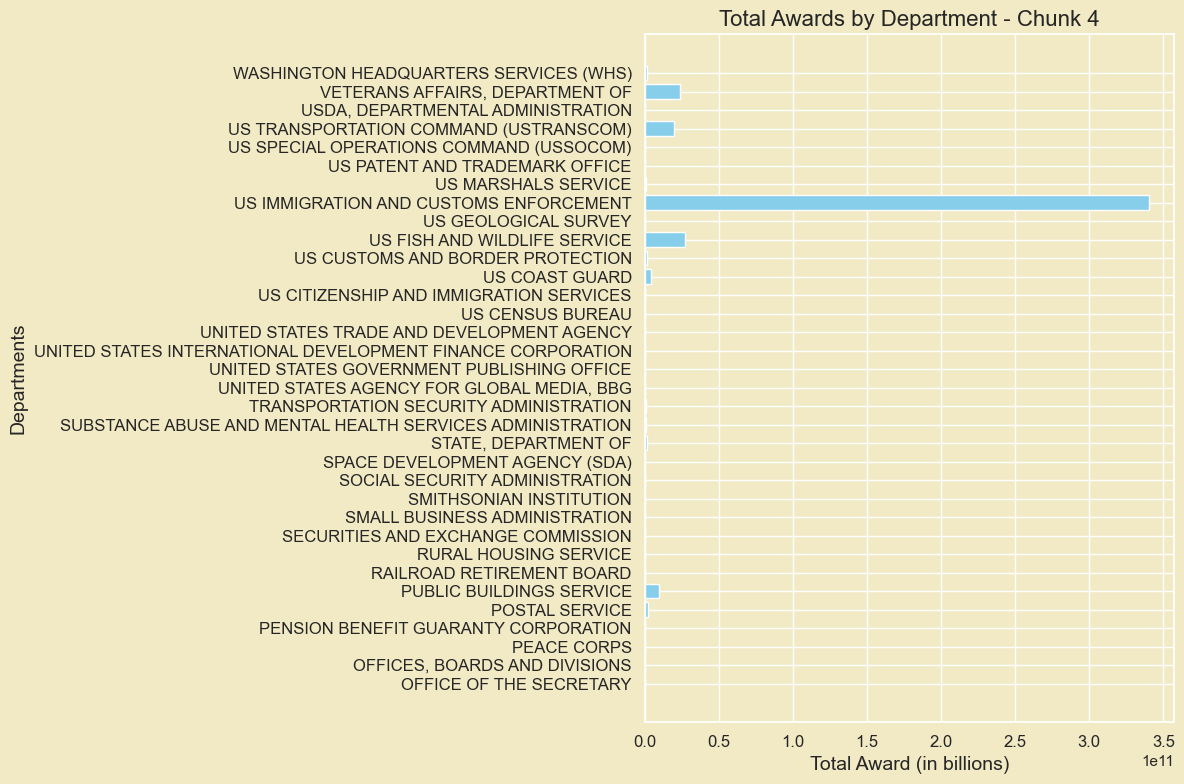

In [13]:
# Ensure departments and total_awards are defined
if departments is not None and total_awards is not None:
    # Determine the number of chunks
    num_chunks = 4
    chunk_size = len(departments) // num_chunks
    chunks = [departments[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

    # If there are remaining departments, add them to the last chunk
    if len(departments) % num_chunks != 0:
        chunks[-1].extend(departments[num_chunks * chunk_size:])

    # Similarly split total_awards into chunks
    total_awards_chunks = [total_awards[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]
    if len(total_awards) % num_chunks != 0:
        total_awards_chunks[-1].extend(total_awards[num_chunks * chunk_size:])

    # Plot histograms for each chunk in separate figures
    for idx, (dept_chunk, award_chunk) in enumerate(zip(chunks, total_awards_chunks), 1):
        plt.figure(figsize=(12, 8))
        plt.barh(dept_chunk, award_chunk, color='skyblue')

        # Add titles and labels
        plt.title(f'Total Awards by Department - Chunk {idx}', fontsize=16)
        plt.xlabel('Total Award (in billions)', fontsize=14)
        plt.ylabel('Departments', fontsize=14)

        # Format tick labels for readability
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # Display the plot
        plt.tight_layout()
        plt.show()
else:
    print("Error: 'departments' or 'total_awards' is not defined.")

In [14]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format
df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,i64
"""bc5e5f04c91646579933a4c0bdc456…",1945,79231,14,17,48,61,1299,1842,178741,0,0,2,652,0,0,0,0,79,0,0,0,0,0,"""No""",16166,793,"""1165526""",11730,"""""","""KAITLYN R. SAWICKI, N732.50, P…","""KAITLYN.SAWICKI@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",44,573,173,54,"""""","""https://sam.gov/opp/bc5e5f04c9…",0
"""a233c35e1ba243928140f6d84b9611…",111305,23721,72,36,181,86,24,811,180942,6,7,2,680,0,0,16954,1029,1569,0,0,0,0,0,"""No""",0,0,"""""",14597,"""Contracting Officer""","""Paul O Waite""","""Paul.Waite@va.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",53,325,400,54,"""""","""https://sam.gov/opp/a233c35e1b…",16579
"""26f9fe72dcfc4e03b9268f7e869e40…",61849,43720,30,75,133,141,1528,1315,69715,1,1,2,607,1,1,7802,940,1489,0,444,186,1329,172,"""No""",0,0,"""""",0,"""""","""Wendy Cruz""","""wendy.cruz@psc.hhs.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",26,627,304,54,"""""","""https://sam.gov/opp/26f9fe72dc…",169166
"""7df37f39a80f4e549a8082ab149982…",33638,42220,30,75,77,135,885,1250,118296,7,8,0,0,0,0,11982,979,1454,0,2053,16,4456,172,"""No""",0,0,"""""",0,"""""","""Tim Walbert""","""timothy.walbert@fda.hhs.gov""","""8705437267""","""""","""""","""""","""""","""""","""""","""OFFICE""",26,710,309,54,"""""","""https://sam.gov/opp/7df37f39a8…",49117
"""0054de1834474a90820b5234927a22…",100592,164987,14,21,47,75,2045,2366,253549,6,7,0,741,11,14,22533,145,1739,0,3401,323,0,172,"""No""",0,0,"""""",0,"""""","""Ann Murphy Adley""","""ann.m.adley@usace.army.mil""","""9783188255""","""""","""""","""""","""""","""""","""""","""OFFICE""",25,165,15,54,"""""","""https://sam.gov/opp/0054de1834…",38609
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""07df9ae0b33b439a85113960fb8990…",41602,152631,14,21,47,75,2083,2064,31545,7,8,0,448,11,14,3754,1036,1504,0,2640,61,0,172,"""No""",0,0,"""""",0,"""""","""Amber Mears""","""amber.l.mears.civ@army.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",37,576,55,54,"""""","""https://sam.gov/opp/07df9ae0b3…",667
"""d3285dc1e3cb4dcd9ab04b2c020274…",3393,107785,14,97,40,180,462,1969,4049,1,1,2,410,0,0,1373,549,80,0,0,0,0,0,"""No""",0,0,"""""",0,"""""","""Questions regarding this solic…","""DibbsBSM@dla.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",53,619,376,54,"""""","""https://sam.gov/opp/d3285dc1e3…",75930
"""d20d1148e5064a9087ab9071de0dbf…",14272,69285,14,17,48,61,1300,1829,147182,6,7,0,643,0,0,15479,455,334,0,0,0,0,0,"""No""",0,0,"""""",0,"""""","""Telephone: 7176052995""","""DAVID.P.MONTEITH@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",44,472,151,54,"""""","""https://sam.gov/opp/d20d1148e5…",28877


In [15]:
award_=df2022['primarycontactemail', 'primarycontactfullname','primarycontactphone', 'award_'].unique()
award_

primarycontactemail,primarycontactfullname,primarycontactphone,award_
str,str,str,str
"""cletus.schafrath@dla.mil""","""Cletus Schafrath614-692-1827""","""""","""9008307.98"""
"""savannah.mincey@us.af.mil""","""Savannah Mincey""","""""",""""""
"""chad.travis.1@us.af.mil""","""Chad Travis""","""8165983013""",""""""
"""marketplacesupport@unisongloba…","""Name: Marketplace Support, Tit…","""""","""33990.0"""
"""laura.l.hedrick@usace.army.mil""","""Laura L Hedrick""","""8163893023""","""493200.00"""
…,…,…,…
"""martin.oakley@dla.mil""","""Martin Oakley""","""5864671254""","""450948.84"""
"""luis.marrero@dla.mil""","""Luis Marrero215-737-2362""","""""","""182428.40"""
"""valerie.c.smith25.civ@us.navy.…","""Valerie Smith""","""8128543588""","""10735948.00"""


In [16]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(award__df):
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'] != "\"\""]
    # Sort by column: 'award_' (descending)
    award__df = award__df.sort_values(['award_'], ascending=[False])
    # Convert 'award_' to numeric and assign to 'award_amount'
    award__df['award_amount'] = pd.to_numeric(award__df['award_'], errors='coerce')
    return award__df

# Loaded variable 'award_' from kernel state
award__df = award_.to_pandas()

award__df_clean = clean_data(award__df.copy())
award__df_clean.head()

,primarycontactemail,primarycontactfullname,primarycontactphone,award_,award_amount
57168,Charles.MielkeII@dla.mil,Charles Mielke614-692-4223,,999999999.00,1.000000e+09
58593,JULIANA.STACK@NAVY.MIL,"JULIANA STACK, N722.22, PHONE (215)697-2560, F...",,999999999,1.000000e+09
41161,Trent.Daniels@dla.mil,Trent DanielsDSN312-850-4683,,99999999.00,1.000000e+08
40211,Charles.MielkeII@dla.mil,Charles Mielke614-692-4223,,99999999.00,1.000000e+08
67002,LESLIE.ADAMS@DLA.MIL,Leslie Adams804-279-5682,,9999999.99,1.000000e+07


In [17]:
# Filter out rows where any of the specified columns are null
filtered_df = award__df_clean.dropna(subset=['primarycontactemail', 'primarycontactfullname', 'primarycontactphone', 'award_amount'])

# Group by the specified columns and calculate the sum of award_amount
grouped_df = filtered_df.groupby(['primarycontactemail', 'primarycontactfullname', 'primarycontactphone']).agg({'award_amount': 'sum'}).reset_index()

# Sort the dataframe by award_amount in descending order and select the top 50
top_50_df = grouped_df.sort_values(by='award_amount', ascending=False).head(25)

# Round the award_amount to 1 decimal place and format with thousands separators
top_50_df['award_amount'] = top_50_df['award_amount'].apply(lambda x: f"{x:,.1f}")

# Display the result
print(top_50_df)

                                 primarycontactemail primarycontactfullname  \
7647                                r5rivera@bop.gov         Rauniel Rivera   
579                    Cristina.Williams@ice.dhs.gov      Cristina Williams   
2292                                      S3@gsa.gov       Mr. Jean Fluevog   
4919                            gordon.scott@gsa.gov           Gordon Scott   
6257                                    kpy2@cdc.gov             Eric Lyons   
1609                        Lance.Nyman@nnsa.doe.gov        Nyman, Lance P.   
4404  dha.ncr.cod-fc.mbx.dha-acq-omnibus-iv@mail.mil          Leslie Nelson   
9085                                    wpn6@cdc.gov    Christina McMichael   
3498                        brian.s.hinerth@nasa.gov          Brian Hinerth   
0                                                                             
3752                  chelan.n.crane.civ@us.navy.mil        Chelan N. Crane   
6677                  marcos.g.kamiyama.civ@army.mil

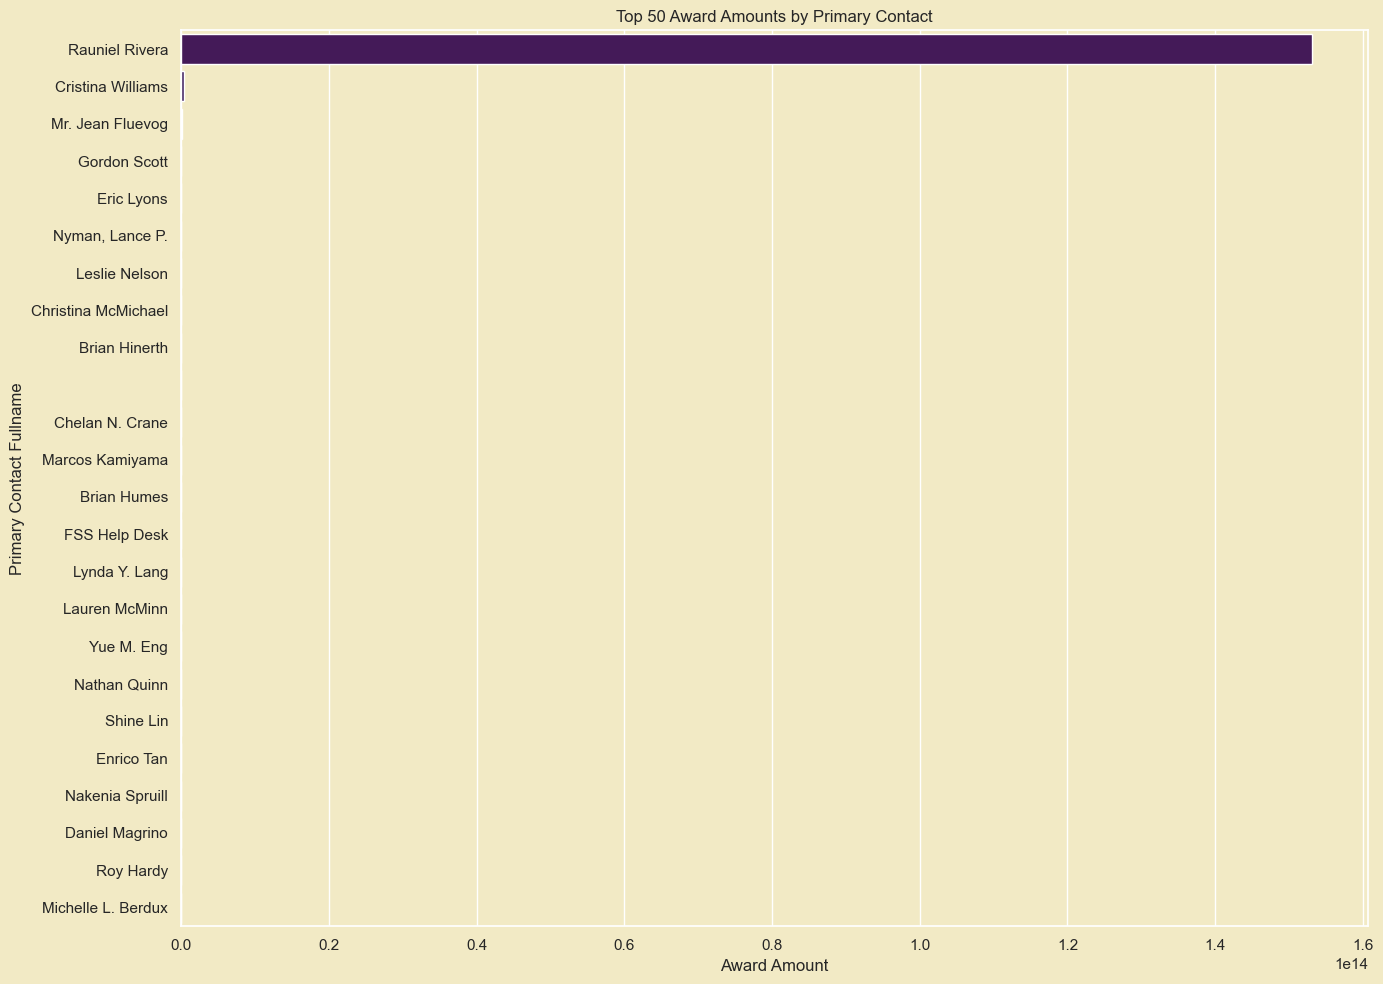

In [18]:
# Convert award_amount back to float for plotting
top_50_df['award_amount'] = top_50_df['award_amount'].str.replace(',', '').astype(float)

# Plot the top 50 award amounts
plt.figure(figsize=(14, 10))
sns.barplot(x='award_amount', y='primarycontactfullname', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact Fullname')
plt.tight_layout()
plt.show()

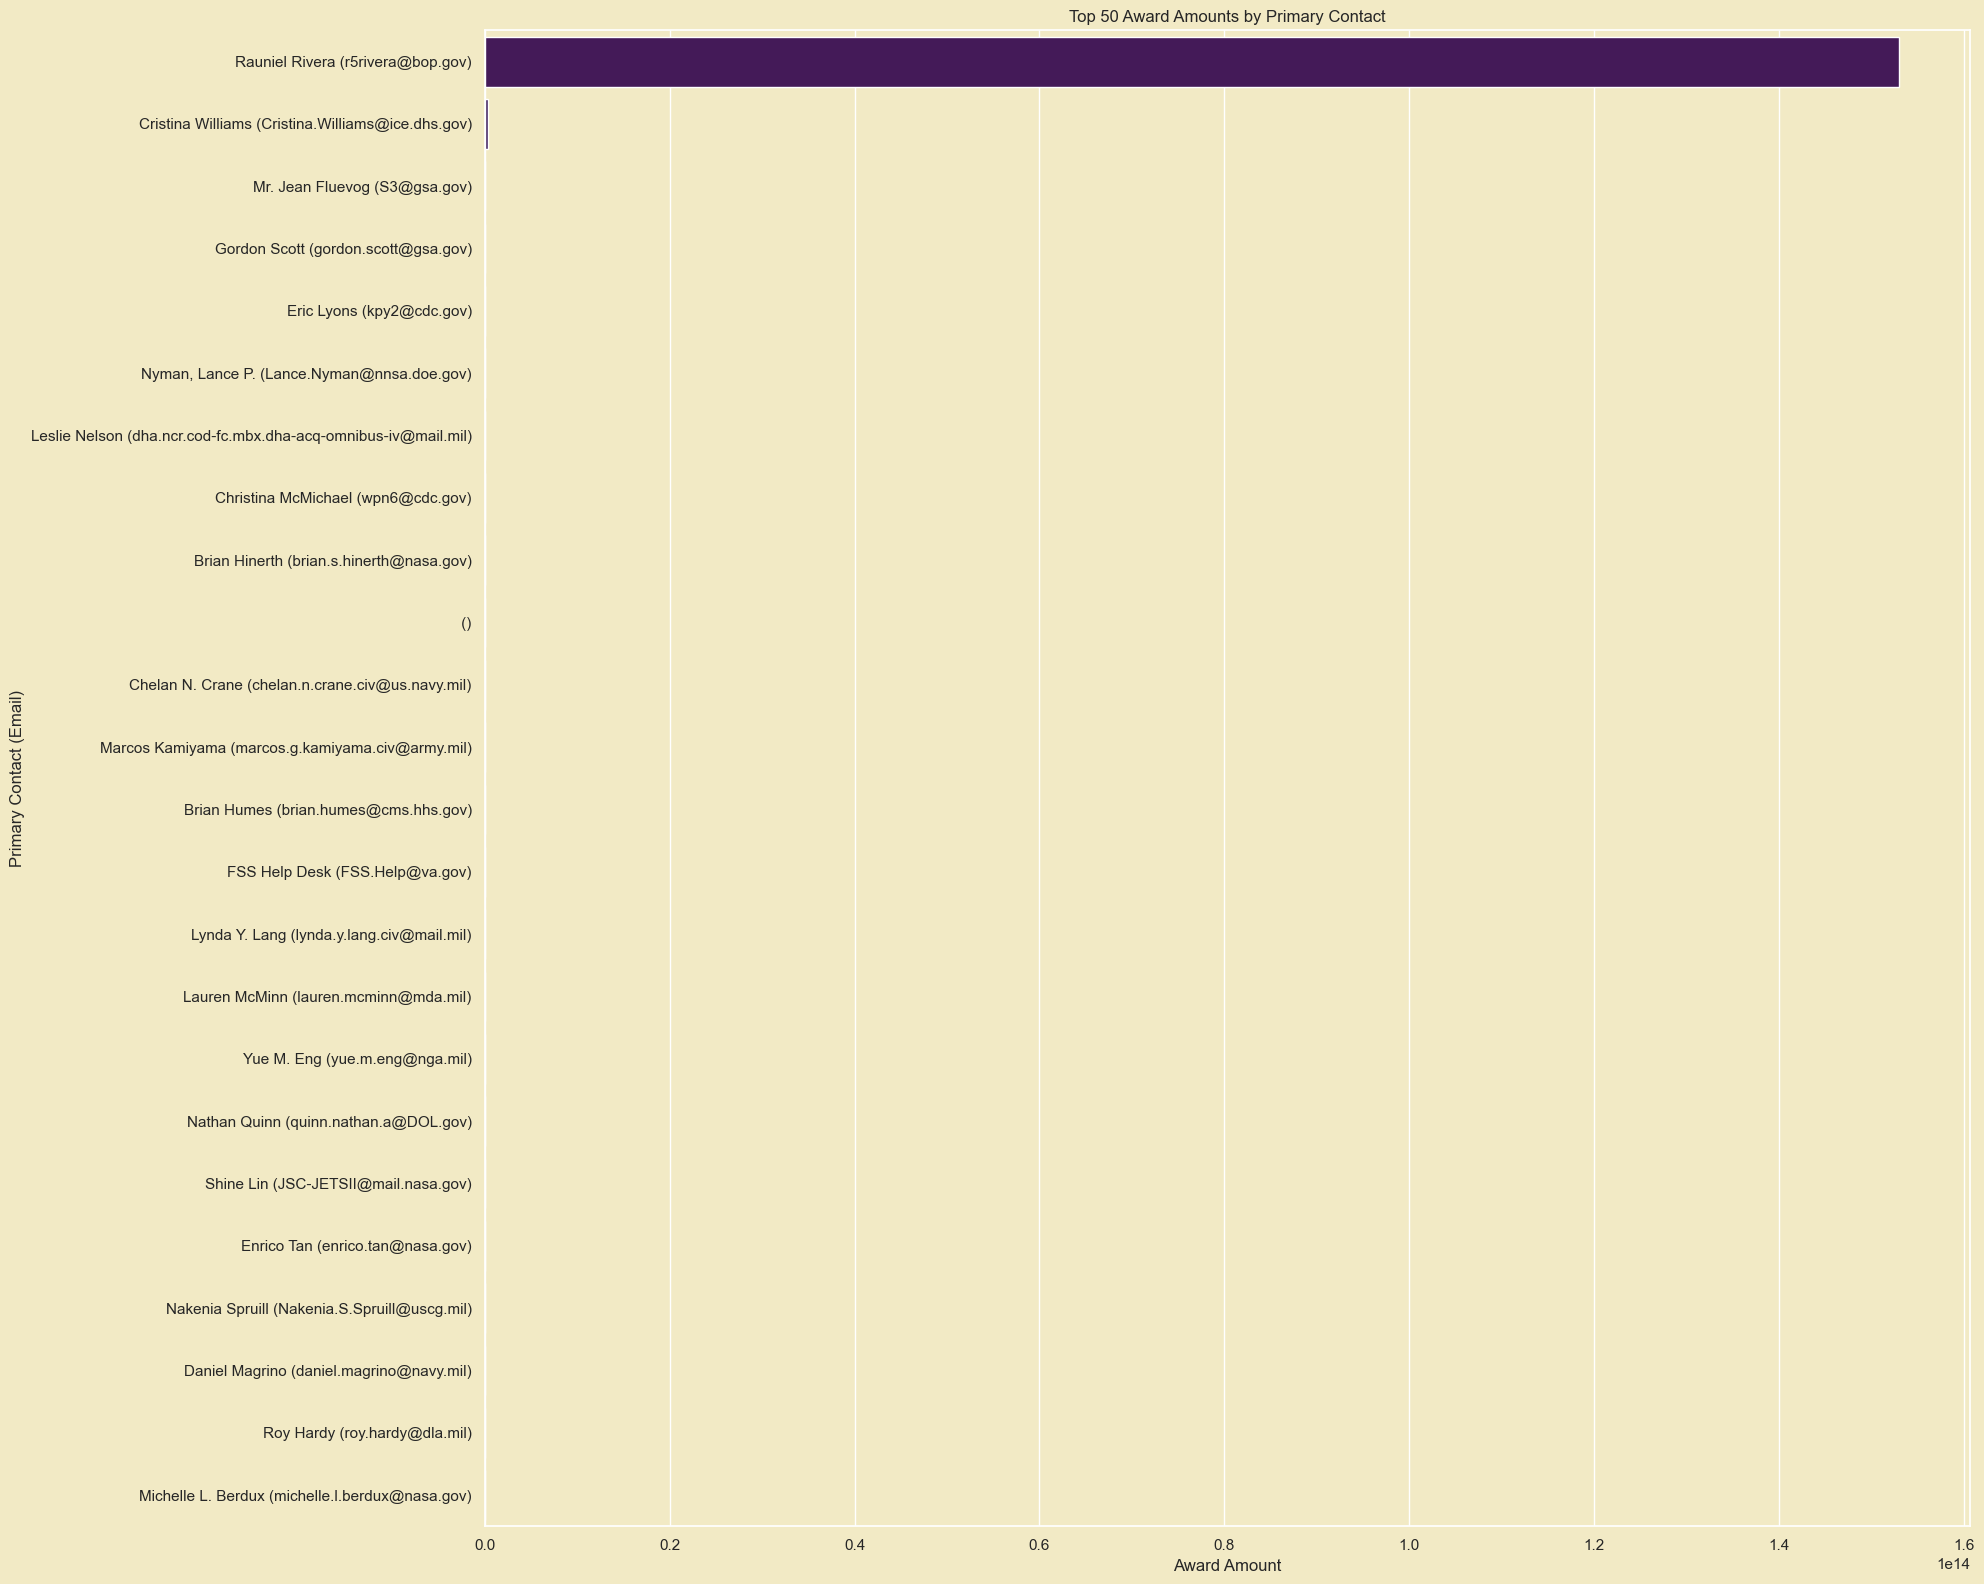

In [19]:
# Concatenate email addresses with primary contact names
top_50_df['contact_info'] = top_50_df['primarycontactfullname'] + ' (' + top_50_df['primarycontactemail'] + ')'

# Plot the top 50 award amounts
plt.figure(figsize=(20, 16))
sns.barplot(x='award_amount', y='contact_info', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact (Email)')
plt.tight_layout()
plt.show()

In [20]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

['noticeid',
 'active',
 'award_',
 'primarycontacttitle',
 'primarycontactfullname',
 'primarycontactemail',
 'primarycontactphone',
 'primarycontactfax',
 'secondarycontacttitle',
 'secondarycontactfullname',
 'secondarycontactemail',
 'secondarycontactphone',
 'secondarycontactfax',
 'organizationtype',
 'additionalinfolink',
 'link']

In [21]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

SimpleImputer()

In [22]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

,noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
0,bc5e5f04c91646579933a4c0bdc456a3,1945,79231,14,17.0,48,61,1299,1842,178741,...,,,OFFICE,44,573,173,54,,https://sam.gov/opp/bc5e5f04c91646579933a4c0bd...,0
8,7dca8a4e32a045e29704583e12fd871f,13817,120004,14,97.0,40,180,483,1990,31828,...,,,OFFICE,41,162,638,54,,https://sam.gov/opp/7dca8a4e32a045e29704583e12...,46522
10,4be36537709540ff82af05c5a4b6ee20,31676,35541,3,12.0,57,19,949,269,53412,...,8168231185,,OFFICE,11,757,206,54,,https://sam.gov/opp/4be36537709540ff82af05c5a4...,177704
19,423819fdf8bf4b2b93447e819f562efb,11863,132380,14,97.0,40,180,483,1999,182439,...,,,OFFICE,41,162,638,54,,https://sam.gov/opp/423819fdf8bf4b2b93447e819f...,0
23,1fccb64e3327482f9f6c9f996c2b5b10,14410,107303,14,97.0,40,180,462,1969,137163,...,,,OFFICE,53,619,376,54,,https://sam.gov/opp/1fccb64e3327482f9f6c9f996c...,0


In [23]:
df2022_df_clean.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award_', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [24]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print(X_train)

                                noticeid   title    sol_  \
53444   f4df36474c374b13ae8053f114cad3bb   68973   63295   
209200  1c1b9a28890641489c4d52ae4f6b469f   18100  126961   
40817   13f9766883d84b18b97f090d4d254009   26704   23305   
77518   512730fcafa94fb0bd5416df77bef266    3571  108627   
52108   bb829e8c7eb747958c5261d2e328116e   12590   69411   
...                                  ...     ...     ...   
59087   dbccfe2a154a4a409df731b434a5f496    9101   97565   
232710  494dd8c13fe640eda0b0fd20e4ea0f41   11858  132116   
198626  7c32c7269f5e446383c6f023d8873fa7   10995  138040   
4557    f1621cefbd304078ad13750085c70351    6033   18605   
82892   956c19700b43481a9cd86ef68d2da7a8  110792   56546   

        department_ind_agency  cgac  sub_tier  fpds_code  office  aac_code  \
53444                      14  17.0        48         61    1352      1898   
209200                     14  97.0        40        180     483      2004   
40817                      72  36.0       181

In [26]:
print(X_test)

                                noticeid   title    sol_  \
50445   ab1288de17f24c3e97068845baa5d968   25255   76695   
94207   b94319e5264044c0a3b636d090b81c6e   17856  128286   
98321   21c4f2b0a0ba463c84065db02d4ca448   12545  139198   
219275  21f596087b144f8a99ccd0acc67bf12c   17265  100063   
3837    f8ee552723dd443b9021160b6521ddde   60116  165344   
...                                  ...     ...     ...   
203566  2cc0e1e04d52444e9529a7b9e2ea0291    6965  116373   
188258  e57777a5f1bd4b67873bde18dc974a85   13860  125169   
180618  76da2ed7e16549c183aad64470e4d9dd   16619  135171   
17105   87efc53f8f284642a9041e3a96d877e2   53188    2959   
102541  3c45339adf8d4b74a67bc3802e690c02  107552   16238   

        department_ind_agency  cgac  sub_tier  fpds_code  office  aac_code  \
50445                      14  17.0        48         61    1299      1842   
94207                      14  97.0        40        180     483      1996   
98321                      14  97.0        40

In [27]:
print(y_train)

53444           38071.00
209200          44880.00
40817     37000.00000000
77518          117000.00
52108             321036
               ...      
59087           92392.00
232710         250000.00
198626          27712.00
4557            85138.55
82892           81987.18
Name: award_, Length: 39680, dtype: object


In [28]:
print(y_test)

50445         829796
94207       28622.40
98321       43000.00
219275      28277.10
3837      1018200.00
             ...    
203566     510855.25
188258     250000.00
180618      15000.00
17105      218679.61
102541     816272.00
Name: award_, Length: 9921, dtype: object


In [29]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [30]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [31]:
X_train.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [32]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

   first_letter  count
0             p     11
1             s     10
2             a      8
3             c      4
4             n      2
5             t      2
6             d      2
7             o      2
8             f      1
9             b      1
10            r      1
11            z      1
12            l      1


In [33]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns ]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

Columns starting with 'a': ['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac', 'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link', 'description']
                                noticeid   title    sol_  \
53444   f4df36474c374b13ae8053f114cad3bb   68973   63295   
209200  1c1b9a28890641489c4d52ae4f6b469f   18100  126961   
40817   13f9766883d84b18b97f090d4d254009   26704   23305   
77518   51

In [34]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [35]:
# Remove the specified columns
X_train = X_train.drop(columns=['noticeid', 'additionalinfolink', 'link'])
X_test = X_test.drop(columns=['noticeid', 'additionalinfolink', 'link'])

# Display the updated dataframes
print(X_train.head())
print(X_test.head())

        title    sol_  department_ind_agency  cgac  sub_tier  fpds_code  \
53444   68973   63295                     14  17.0        48         61   
209200  18100  126961                     14  97.0        40        180   
40817   26704   23305                     72  36.0       181         86   
77518    3571  108627                     14  97.0        40        180   
52108   12590   69411                     14  17.0        48         61   

        office  aac_code  posteddate  type  ...  secondarycontactfullname  \
53444     1352      1898      213115     0  ...                             
209200     483      2004       26799     0  ...                             
40817       24       811       11724     0  ...                             
77518      462      1969      249128     0  ...                             
52108     1300      1829      240980     0  ...                             

        secondarycontactemail  secondarycontactphone  secondarycontactfax  \
53444    

In [36]:
# Remove '$' and ',' then convert to float
#y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [37]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 43
Number of columns in X_test: 43


In [38]:
# Identify object columns
object_columns = X_train.select_dtypes(include=['object']).columns

# Clean columns containing '$'
for col in object_columns:
    if X_train[col].astype(str).str.contains('\$').any():
        X_train[col] = X_train[col].str.replace(r'[\$,]', '', regex=True).astype(float)
        X_test[col] = X_test[col].str.replace(r'[\$,]', '', regex=True).astype(float)

# Drop non-numeric columns without '$'
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

# Ensure X_train and X_test have the same columns
X_test = X_test[X_train.columns]


In [39]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

ValueError: could not convert string to float: '$11,497,348.00'

In [ ]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

XGBoost MSE: 8.880405587808886e+17, R2: -46.97241884927594


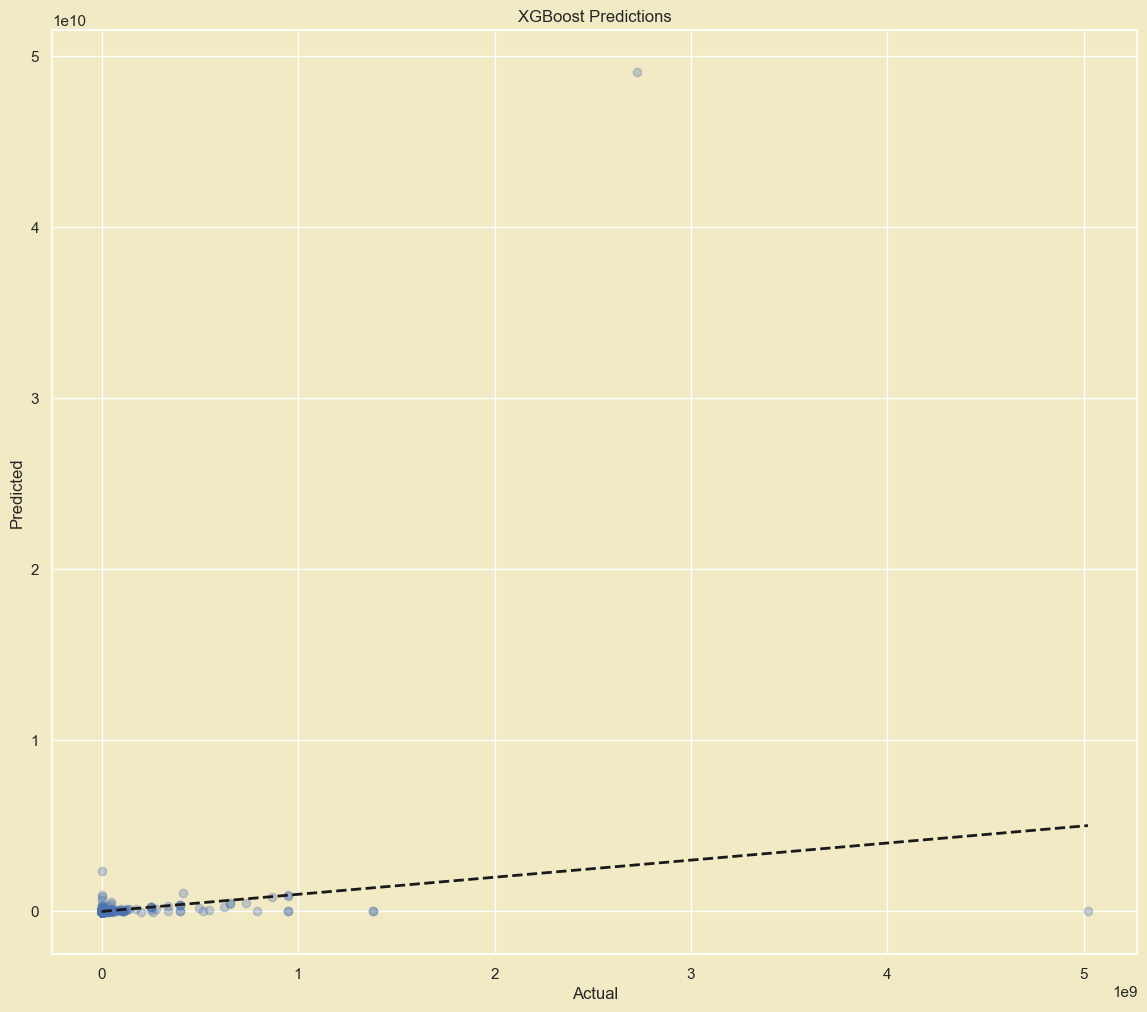

In [ ]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(14, 12))
plt.scatter(y_test / 1e6, xgb_predictions / 1e6, alpha=0.3)
plt.plot([y_test.min() / 1e6, y_test.max() / 1e6], [y_test.min() / 1e6, y_test.max() / 1e6], 'k--', lw=2)
plt.xlabel('Actual (in millions)')
plt.ylabel('Predicted (in millions)')
plt.title('XGBoost Predictions')
plt.show()

In [ ]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [ ]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, 
                       posted_date, contract_type, base_type, archive_type, darchive_date, 
                       set_aside_code, set_aside, response_deadline, naics_code, 
                       classification_code, pop_street_address, pop_city, pop_state,
                       pop_zip, pop_country, award_number, award_date, award_amount,
                       awardee, primary_contact_title, primary_contact_fullname,
                       primary_contact_email, primary_contact_phone, primary_contact_fax, 
                       secondary_contact_title, secondary_contact_fullname, secondary_contact_email, 
                       secondary_contact_phone, secondary_contact_fax, organization_type, state, 
                       city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [ ]:
X_train.dtypes.to_frame('Data Type')

,Data Type
title,int64
sol_,int64
department_ind_agency,int64
cgac,float64
sub_tier,int64
fpds_code,int64
office,int64
aac_code,int64
posteddate,int64
type,int64


In [ ]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

9861 row(s) have 0 missing values
Total number of rows with missing values: 0


In [ ]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

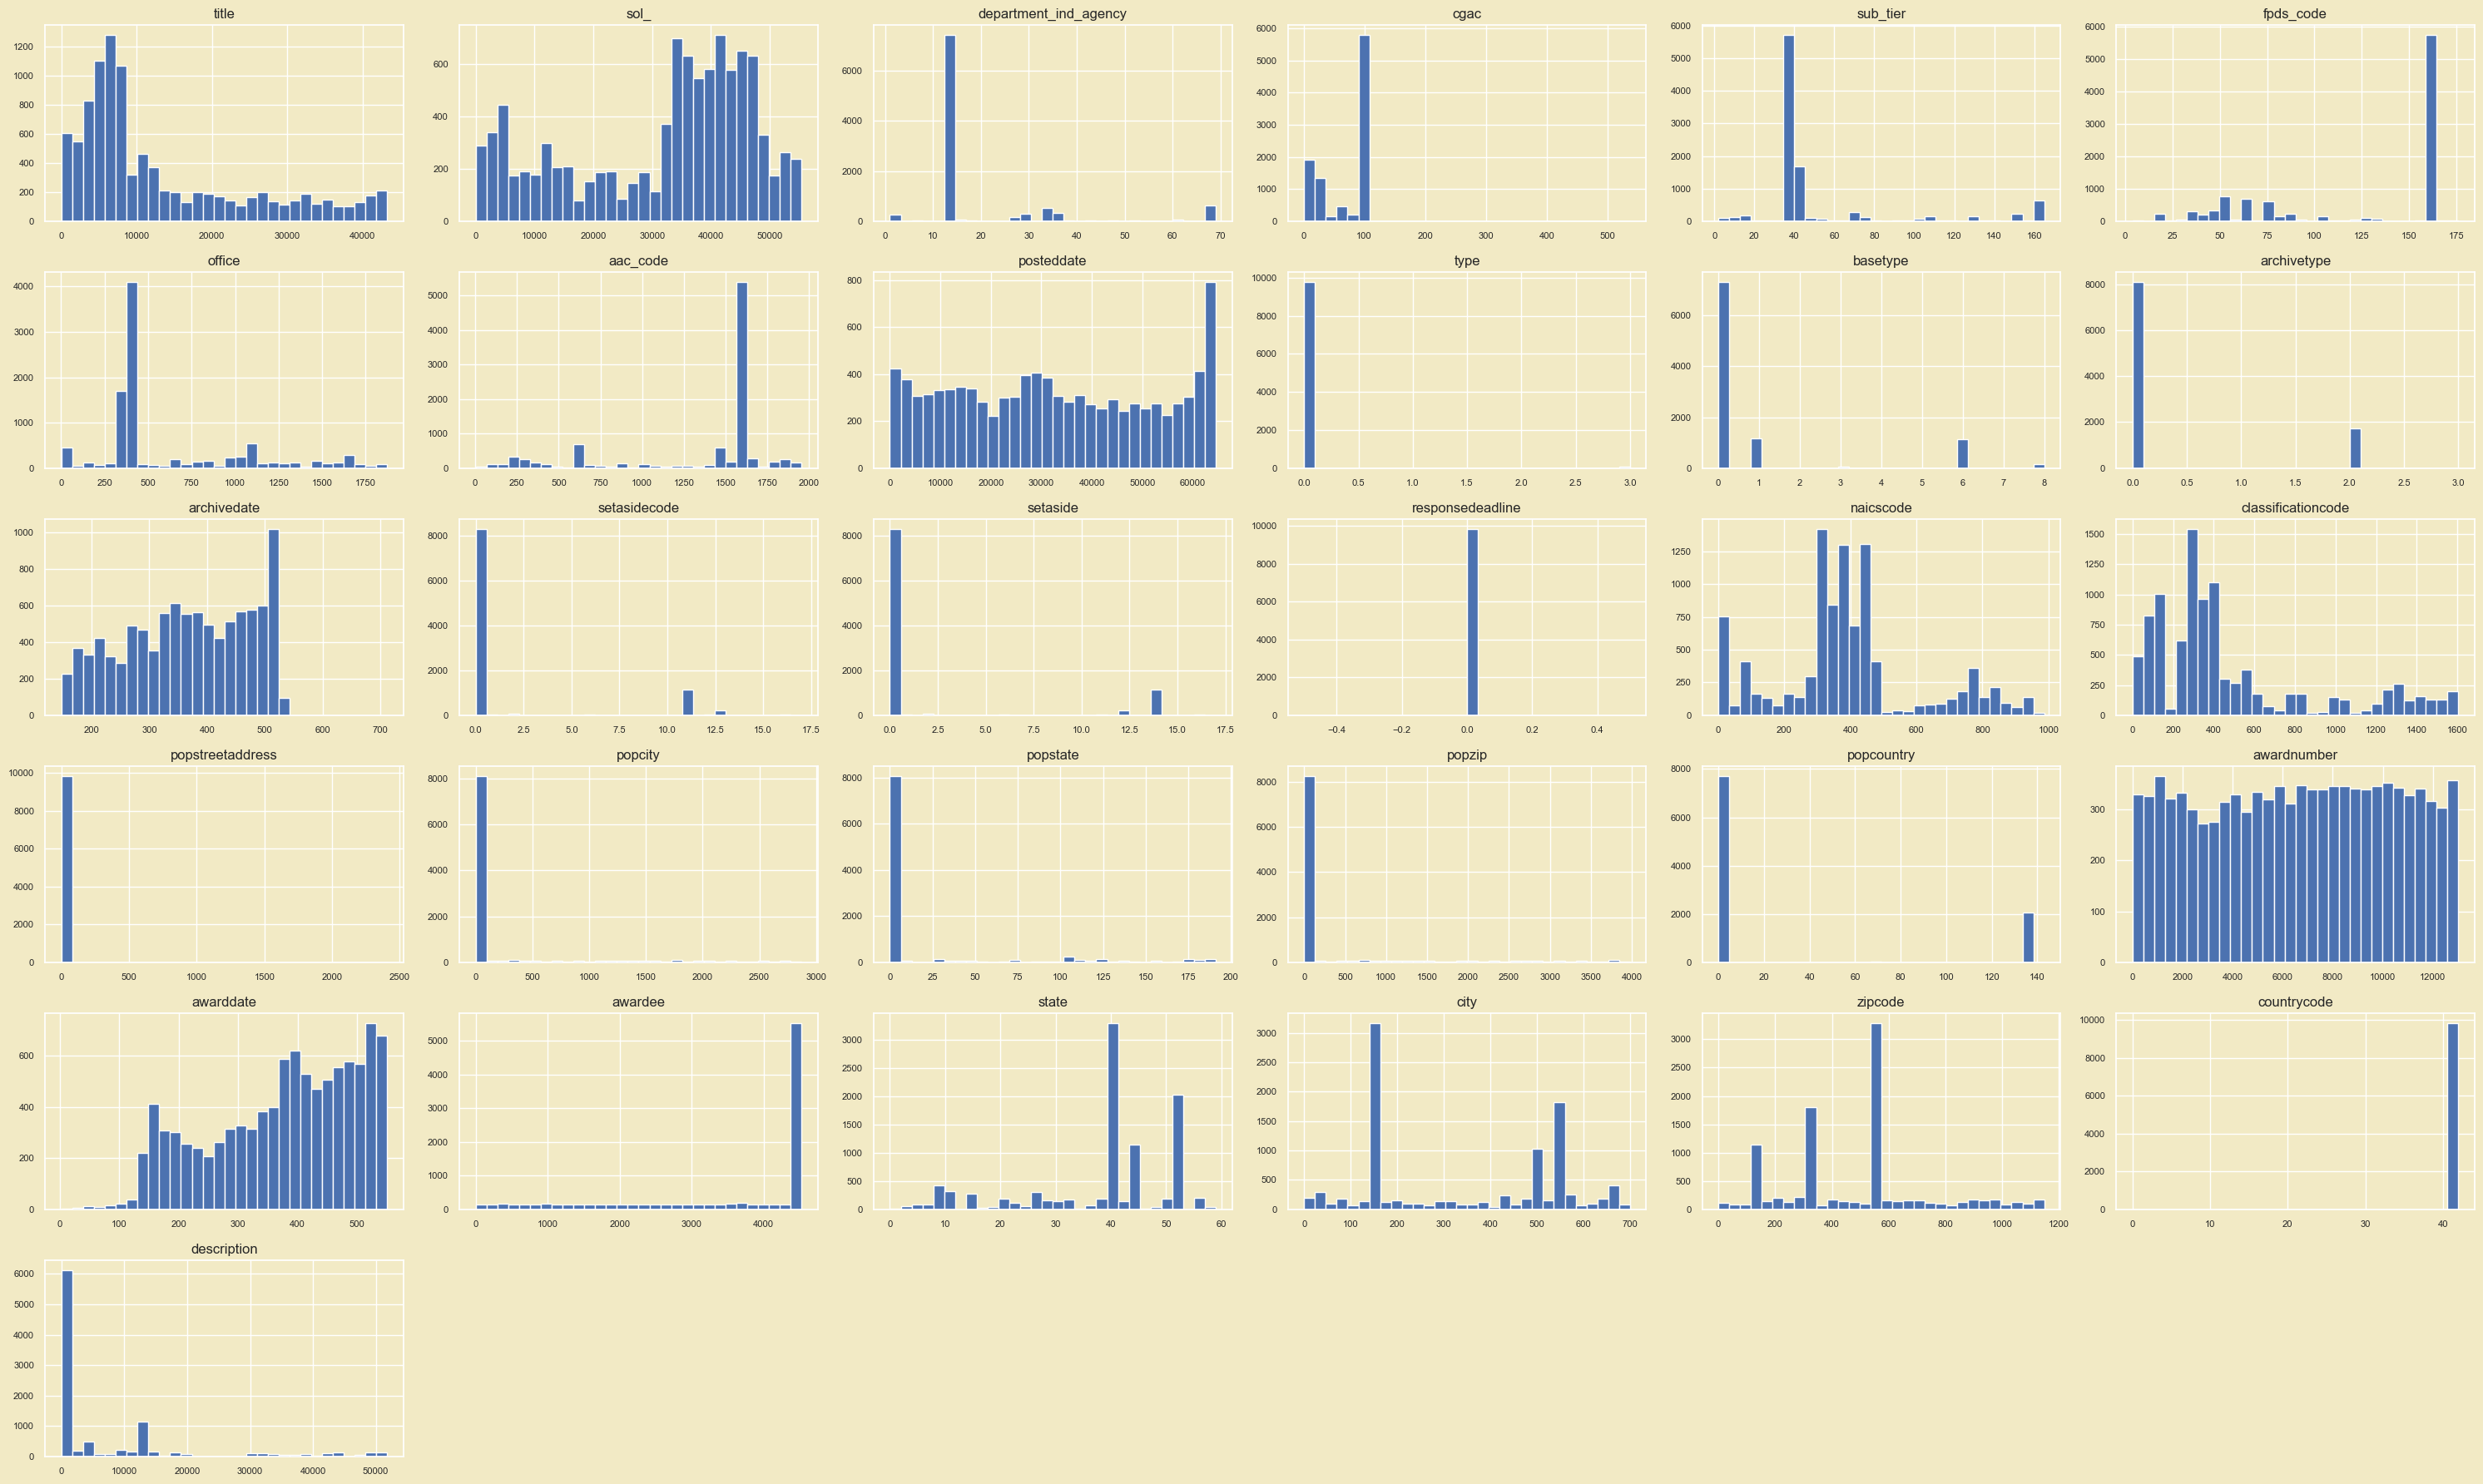

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(30,18), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

<Figure size 3200x1500 with 0 Axes>

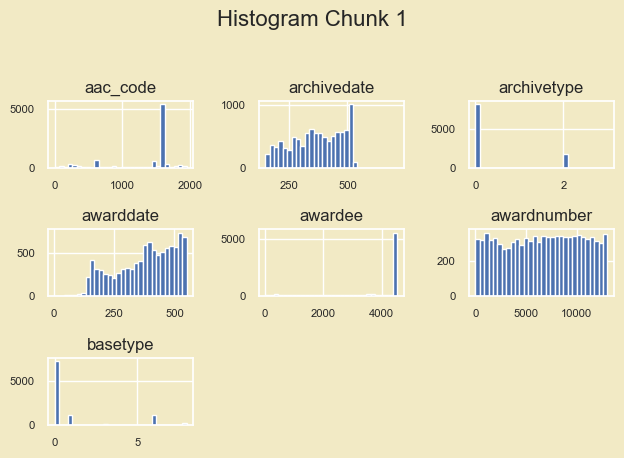

<Figure size 3200x1500 with 0 Axes>

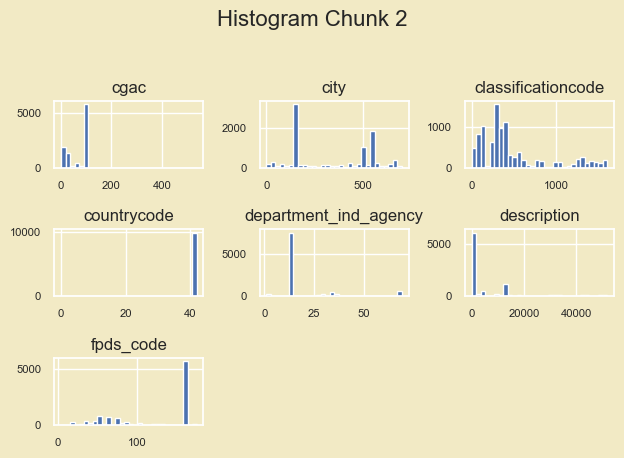

<Figure size 3200x1500 with 0 Axes>

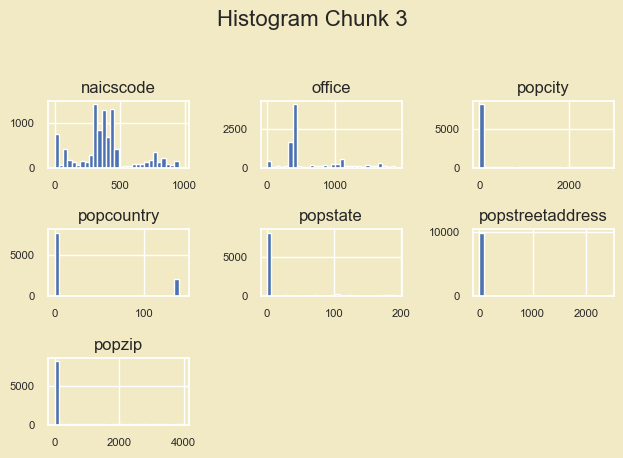

<Figure size 3200x1500 with 0 Axes>

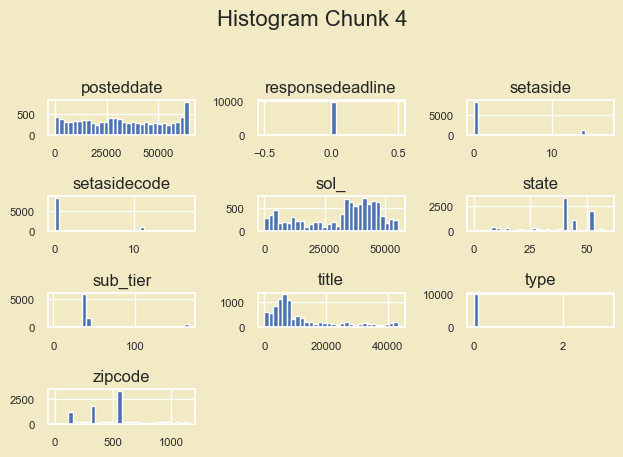

In [ ]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Sort the columns by names
sorted_columns = sorted(X_train.columns)

# Split columns into four roughly equal parts
num_chunks = 4
chunk_size = len(sorted_columns) // num_chunks
chunks = [sorted_columns[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining columns, add them to the last chunk
if len(sorted_columns) % num_chunks != 0:
    chunks[-1].extend(sorted_columns[num_chunks * chunk_size:])

# Plot histograms for each chunk
for idx, chunk in enumerate(chunks, 1):
    plt.figure(figsize=(32, 15))
    X_train[chunk].hist(bins=30, xlabelsize=8, ylabelsize=8)
    plt.suptitle(f'Histogram Chunk {idx}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
unique_values = X_train.nunique()
missing_values = X_train.isnull().sum()

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'Missing Values': missing_values
})

In [ ]:
summary_sorted = summary.sort_values(by='Unique Values', ascending=True)

print(summary_sorted)

                       Unique Values  Missing Values
responsedeadline                   1               0
type                               2               0
archivetype                        3               0
popstreetaddress                   5               0
basetype                           6               0
countrycode                       11               0
setasidecode                      15               0
setaside                          15               0
department_ind_agency             34               0
cgac                              35               0
popcountry                        39               0
state                             56               0
popstate                          64               0
sub_tier                          90               0
fpds_code                         91               0
archivedate                      382               0
city                             403               0
awarddate                        467          

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9861 entries, 1589 to 38325
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  9861 non-null   int64  
 1   sol_                   9861 non-null   int64  
 2   department_ind_agency  9861 non-null   int64  
 3   cgac                   9861 non-null   float64
 4   sub_tier               9861 non-null   int64  
 5   fpds_code              9861 non-null   int64  
 6   office                 9861 non-null   int64  
 7   aac_code               9861 non-null   int64  
 8   posteddate             9861 non-null   int64  
 9   type                   9861 non-null   int64  
 10  basetype               9861 non-null   int64  
 11  archivetype            9861 non-null   int64  
 12  archivedate            9861 non-null   int64  
 13  setasidecode           9861 non-null   int64  
 14  setaside               9861 non-null   int64  
 15  respo

In [ ]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")

Random Forest MSE: 1.0287082922172995e+17, R2: -4.557136392026883
Ridge Regression MSE: 2.3005982160520384e+16, R2: -0.24279527700689707


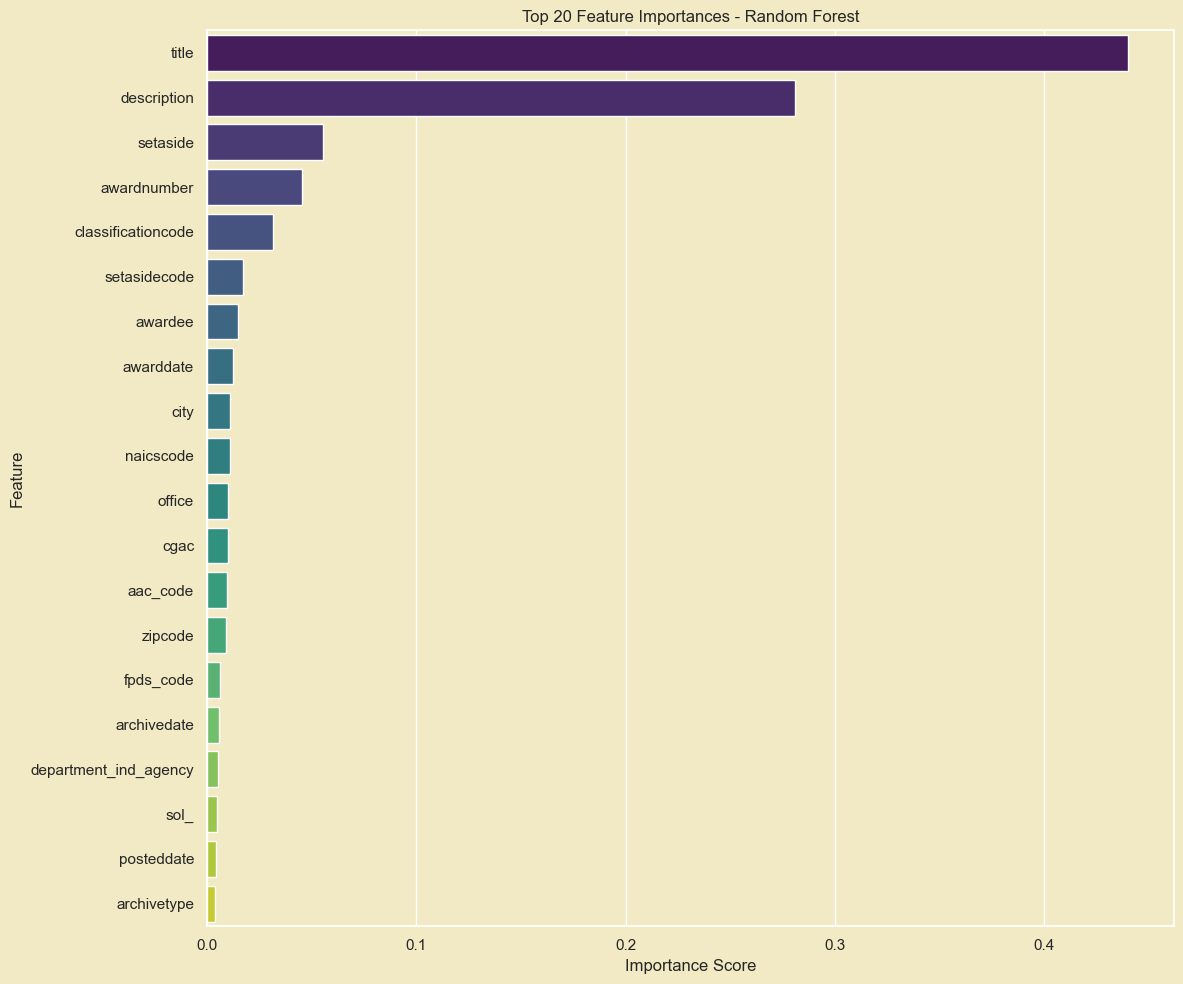

In [ ]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# 1. Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)  # Top 20 features

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

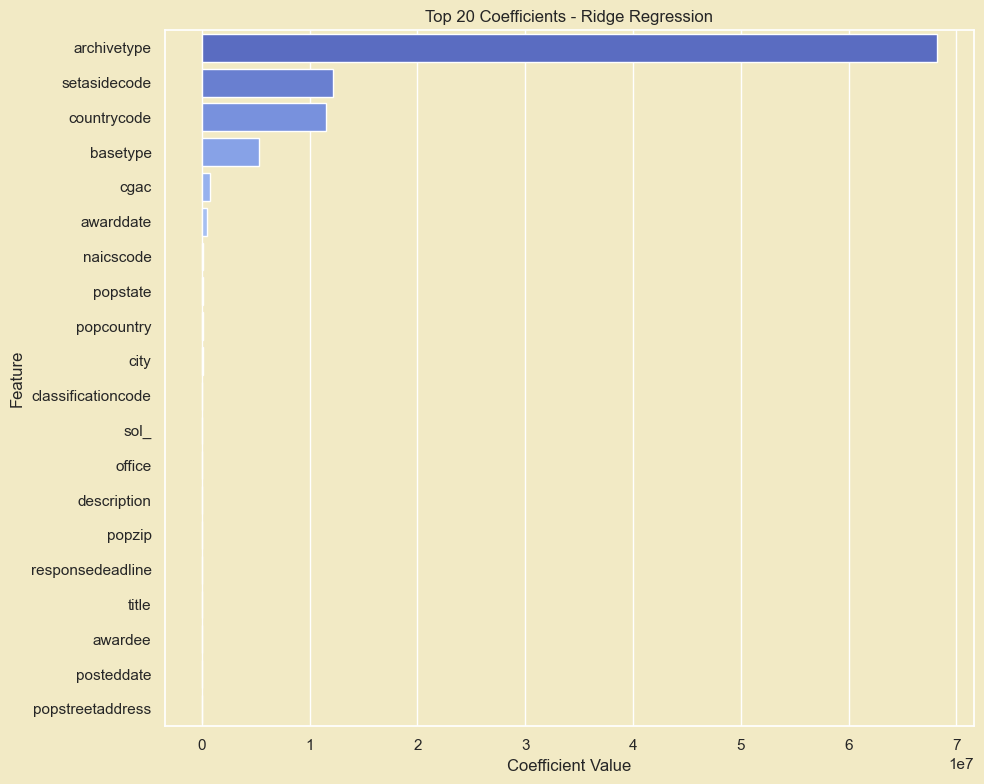

In [ ]:
# 2. Coefficient Analysis for Ridge Regression
coefficients = ridge_model.coef_
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False).head(20)  # Top 20 positive coefficients

plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=coef_df, palette='coolwarm')
plt.title('Top 20 Coefficients - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

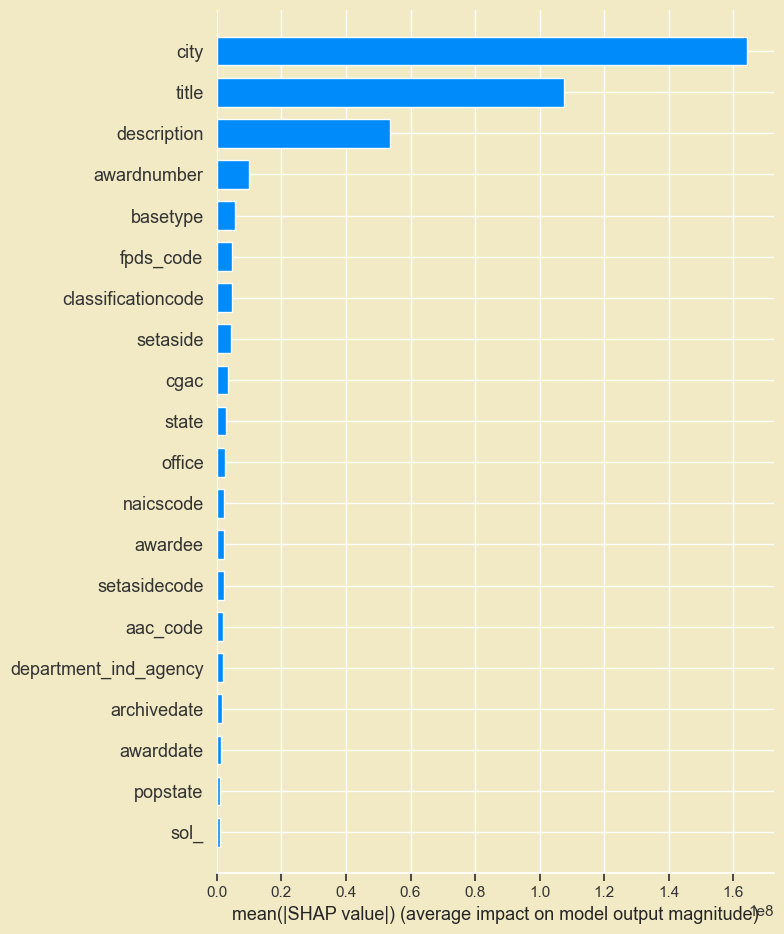

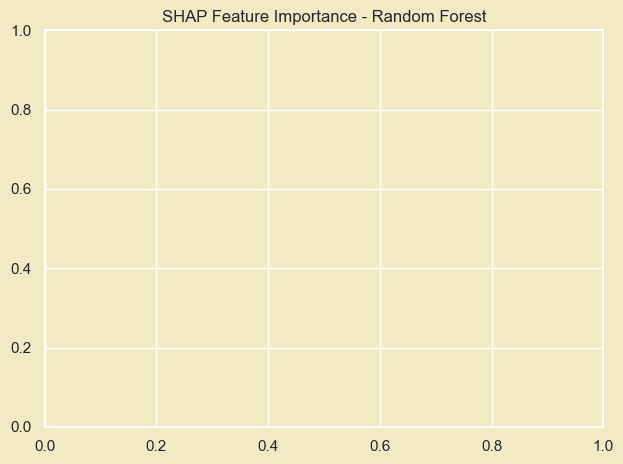

In [ ]:
# 3. SHAP Values for Model Explainability
# Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.title('SHAP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

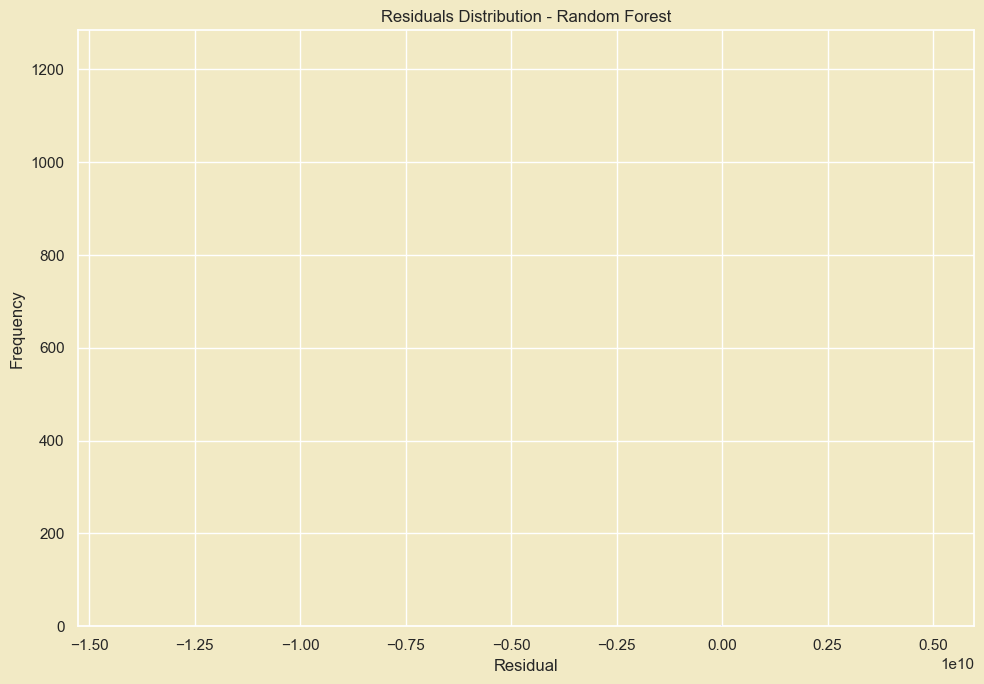

In [ ]:
# 4. Residual Plots
# Random Forest Residuals
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(10, 7))
sns.histplot(rf_residuals, kde=False, color='blue')
plt.title('Residuals Distribution - Random Forest')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

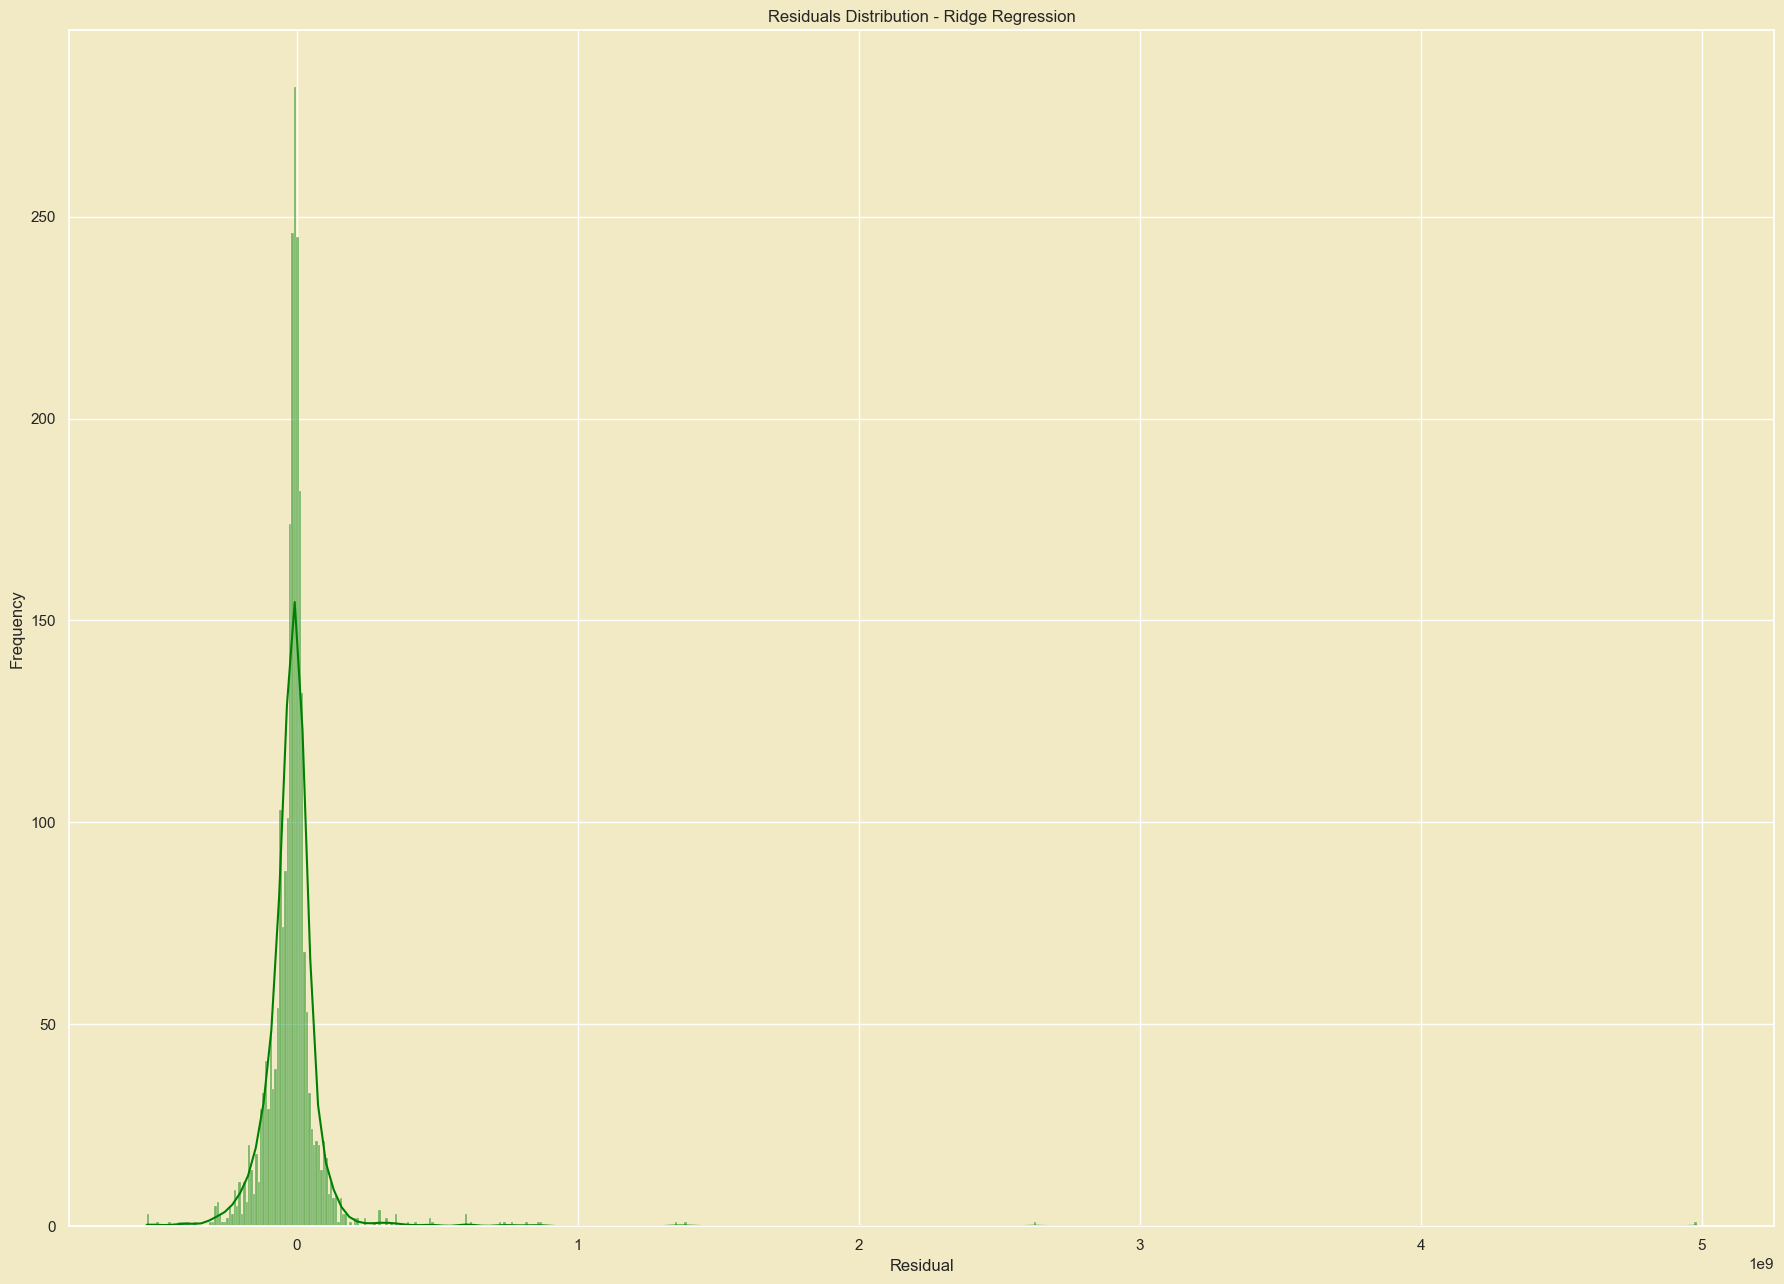

In [ ]:
# Ridge Regression Residuals
ridge_residuals = y_test - ridge_predictions
plt.figure(figsize=(18, 13))
sns.histplot(ridge_residuals, kde=True, color='green')
plt.title('Residuals Distribution - Ridge Regression')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

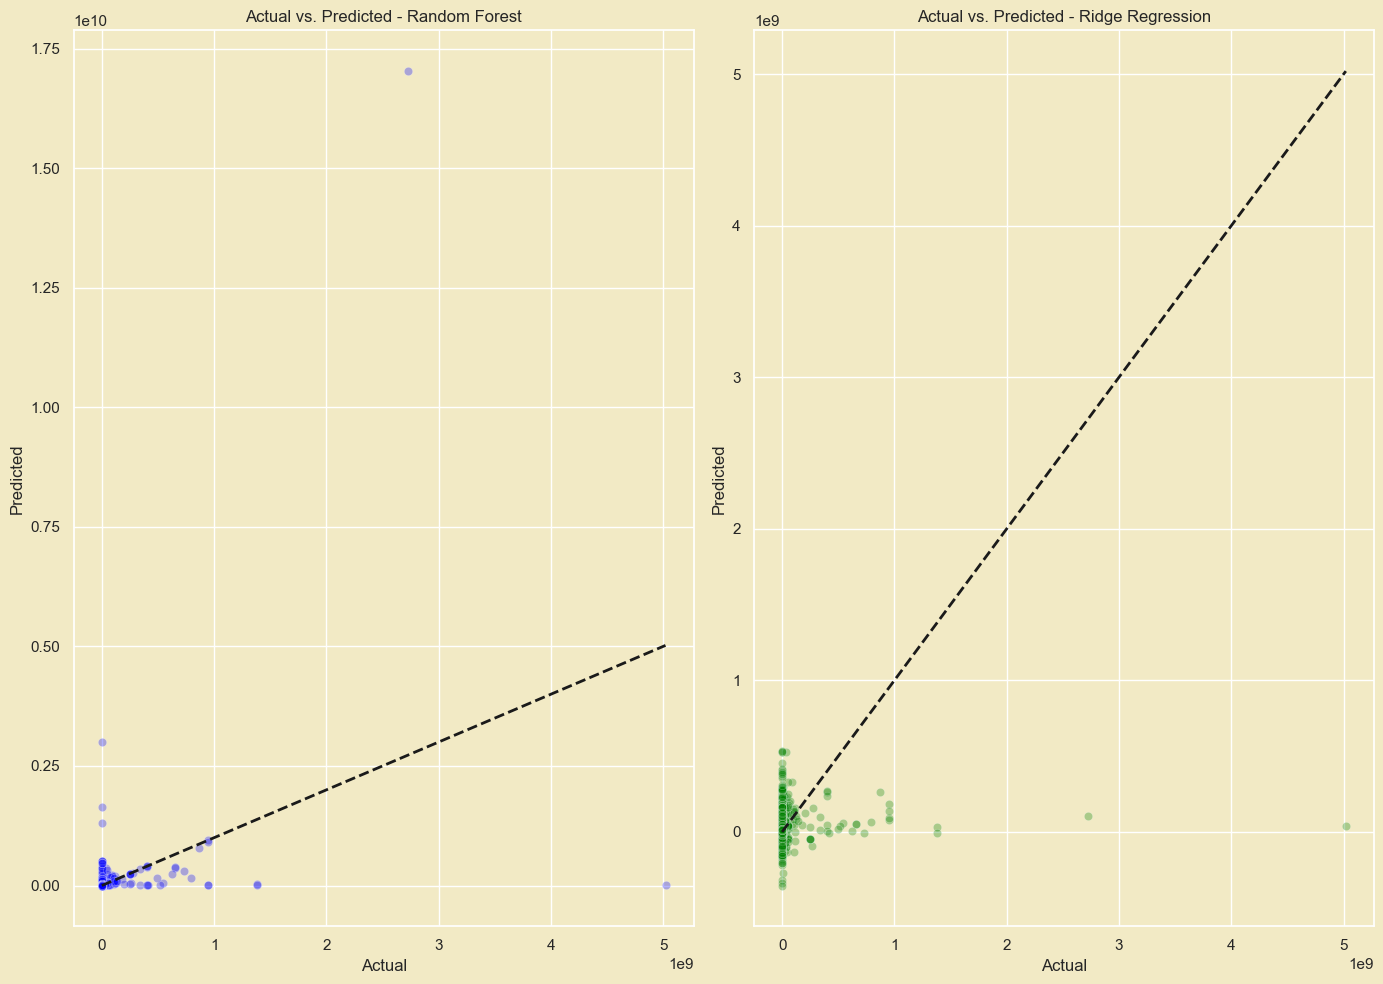

In [ ]:
# 5. Actual vs. Predicted Scatter Plots
plt.figure(figsize=(14, 10))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Random Forest')

# Ridge Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=ridge_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Ridge Regression')

plt.tight_layout()
plt.show()

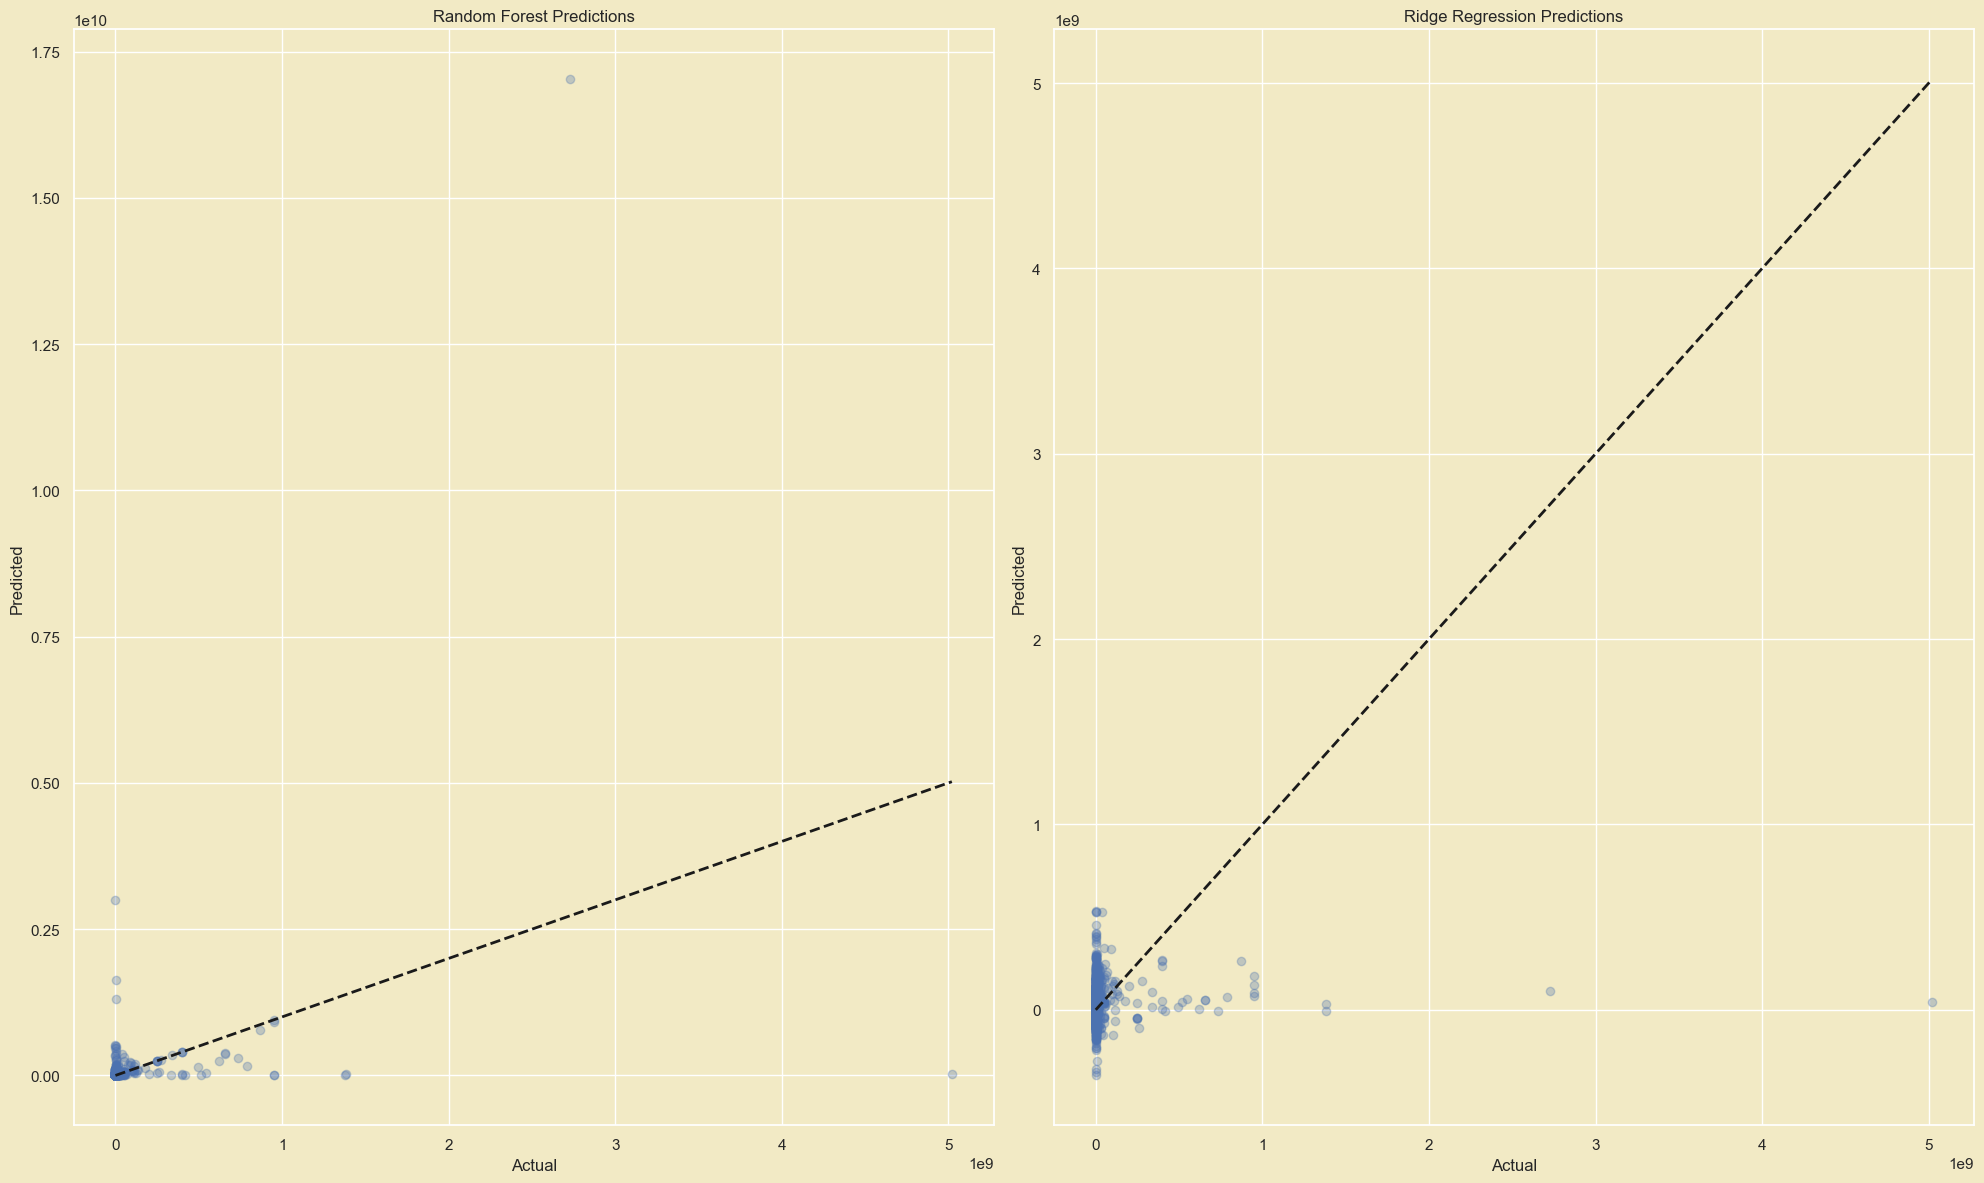

In [ ]:
# Plot the results
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()